In [1]:
import time
import datetime
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


def scale_list(l, to_min, to_max):
    def scale_number(unscaled, to_min, to_max, from_min, from_max):
        return (to_max - to_min) * (unscaled - from_min) / (from_max - from_min) + to_min

    if len(set(l)) == 1:
        return [np.floor((to_max + to_min) / 2)] * len(l)
    else:
        return [scale_number(i, to_min, to_max, min(l), max(l)) for i in l]


STOCKS = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'TSLA', 'NFLX']

TIME_RANGE = 20
PRICE_RANGE = 20
VALIDATION_CUTOFF_DATE = datetime.date(2017, 7, 1)

half_scale_size = int(PRICE_RANGE / 2)

live_symbols = []
x_live = None
x_train = None
x_valid = None
y_train = []
y_valid = []

for stock in STOCKS:
    print(stock)

    # Download stock data using yfinance
    stock_data = yf.download(stock)
    stock_data['Symbol'] = stock
    stock_data['Date'] = stock_data.index
    stock_data['Date'] = pd.to_datetime(stock_data['Date'], infer_datetime_format=True)
    stock_data['Date'] = stock_data['Date'].dt.date
    stock_data = stock_data.reset_index(drop=True)

    # Add Moving Averages to all lists and backfill resulting first NAs to last known value
    noise_ma_smoother = 3
    stock_closes = stock_data['Close'].rolling(window=noise_ma_smoother).mean()
    stock_closes = stock_closes.fillna(method='bfill')
    stock_closes = list(stock_closes.values)
    stock_opens = stock_data['Open'].rolling(window=noise_ma_smoother).mean()
    stock_opens = stock_opens.fillna(method='bfill')
    stock_opens = list(stock_opens.values)

    stock_dates = stock_data['Date'].values
    close_minus_open = list(np.array(stock_closes) - np.array(stock_opens))

    # Add a rolling average as an overlay indicator and backfill missing values
    longer_ma_smoother = 6
    stock_closes_rolling_avg = stock_data['Close'].rolling(window=longer_ma_smoother).mean()
    stock_closes_rolling_avg = stock_closes_rolling_avg.fillna(method='bfill')
    stock_closes_rolling_avg = list(stock_closes_rolling_avg.values)

    for cnt in range(4, len(stock_closes)):
        if cnt % 500 == 0:
            print(cnt)

        if cnt >= TIME_RANGE:
            # Start making images
            graph_open = list(np.round(scale_list(stock_opens[cnt - TIME_RANGE:cnt], 0, half_scale_size - 1), 0))
            graph_close_minus_open = list(
                np.round(scale_list(close_minus_open[cnt - TIME_RANGE:cnt], 0, half_scale_size - 1), 0))

            # Scale both close and close MA together
            close_data_together = list(np.round(scale_list(list(stock_closes[cnt - TIME_RANGE:cnt]) +
                                                           list(stock_closes_rolling_avg[cnt - TIME_RANGE:cnt]), 0,
                                                           half_scale_size - 1), 0))
            graph_close = close_data_together[0:PRICE_RANGE]
            graph_close_ma = close_data_together[PRICE_RANGE:]

            outcome = None
            if cnt < len(stock_closes) - 1:
                outcome = 0
                if stock_closes[cnt + 1] > stock_closes_rolling_avg[cnt + 1]:
                    outcome = 1

            blank_matrix_close = np.zeros(shape=(half_scale_size, TIME_RANGE))
            x_ind = 0
            for ma, c in zip(graph_close_ma, graph_close):
                blank_matrix_close[int(ma), x_ind] = 1
                blank_matrix_close[int(c), x_ind] = 2
                x_ind += 1

            # Flip x scale so high number is atop, low number at bottom - cosmetic, humans only
            blank_matrix_close = blank_matrix_close[::-1]

            blank_matrix_diff = np.zeros(shape=(half_scale_size, TIME_RANGE))
            x_ind = 0
            for v in graph_close_minus_open:
                blank_matrix_diff[int(v), x_ind] = 3
                x_ind += 1

            # Flip x scale so high number is atop, low number at bottom - cosmetic, humans only
            blank_matrix_diff = blank_matrix_diff[::-1]

            blank_matrix = np.vstack([blank_matrix_close, blank_matrix_diff])

            if outcome is None:
                # Live data
                if x_live is None:
                    x_live = [blank_matrix]
                else:
                    x_live = np.vstack([x_live, [blank_matrix]])
                live_symbols.append(stock)

            elif stock_dates[cnt] >= VALIDATION_CUTOFF_DATE:
                # Validation data
                if x_valid is None:
                    x_valid = [blank_matrix]
                else:
                    x_valid = np.vstack([x_valid, [blank_matrix]])
                y_valid.append(outcome)

            else:
                # Training data
                if x_train is None:
                    x_train = [blank_matrix]
                else:
                    x_train = np.vstack([x_train, [blank_matrix]])
                y_train.append(outcome)


AAPL


[*********************100%%**********************]  1 of 1 completed
C:\Users\Hamza\AppData\Local\Temp\ipykernel_13744\1010183021.py:41: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  stock_data['Date'] = pd.to_datetime(stock_data['Date'], infer_datetime_format=True)


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
GOOG


[*********************100%%**********************]  1 of 1 completed
C:\Users\Hamza\AppData\Local\Temp\ipykernel_13744\1010183021.py:41: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  stock_data['Date'] = pd.to_datetime(stock_data['Date'], infer_datetime_format=True)


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
MSFT


[*********************100%%**********************]  1 of 1 completed
C:\Users\Hamza\AppData\Local\Temp\ipykernel_13744\1010183021.py:41: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  stock_data['Date'] = pd.to_datetime(stock_data['Date'], infer_datetime_format=True)


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
AMZN


[*********************100%%**********************]  1 of 1 completed
C:\Users\Hamza\AppData\Local\Temp\ipykernel_13744\1010183021.py:41: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  stock_data['Date'] = pd.to_datetime(stock_data['Date'], infer_datetime_format=True)


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
TSLA


[*********************100%%**********************]  1 of 1 completed
C:\Users\Hamza\AppData\Local\Temp\ipykernel_13744\1010183021.py:41: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  stock_data['Date'] = pd.to_datetime(stock_data['Date'], infer_datetime_format=True)


500
1000
1500
2000
2500
3000
3500
NFLX


[*********************100%%**********************]  1 of 1 completed
C:\Users\Hamza\AppData\Local\Temp\ipykernel_13744\1010183021.py:41: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  stock_data['Date'] = pd.to_datetime(stock_data['Date'], infer_datetime_format=True)


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


C:\Users\Hamza\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 16, 64)              │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 14, 32)              │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          28,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           6,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,861 (163.52 KB)

 Trainable params: 41,861 (163.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 5.2066 - mean_squared_error: 5.2066 - val_loss: 2.2147 - val_mean_squared_error: 2.2147
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0759 - mean_squared_error: 5.0759 - val_loss: 1.7027 - val_mean_squared_error: 1.7027
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3267 - mean_squared_error: 4.3267 - val_loss: 1.4317 - val_mean_squared_error: 1.4317
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.3193 - mean_squared_error: 3.3193 - val_loss: 1.1989 - val_mean_squared_error: 1.1989
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6132 - mean_squared_error: 2.6132 - val_loss: 1.0950 - val_mean_squared_error: 1.0950
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4222 - mean_squared_error: 2.4222 - val_loss: 1.1067 - val_mean_squared_error: 1.1067
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3167 - mean_squared_error: 2.3167 - val_loss: 1.0639 - val_me

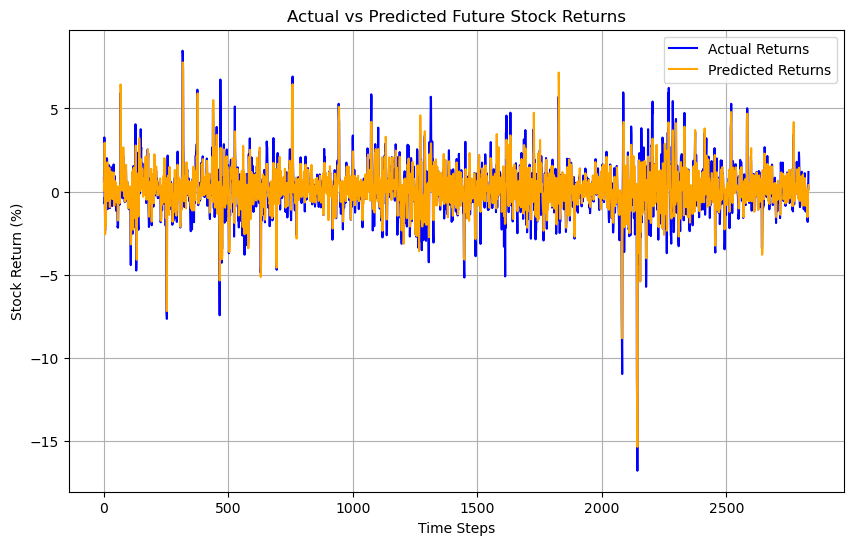

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
import numpy as np
import matplotlib.pyplot as plt

# Adjusted parameters for time series forecasting
batch_size = 100
epochs = 20

# Time range (window of past returns to predict the next return)
TIME_RANGE = 20

# Prepare input data for time series forecasting
def prepare_data(data, time_range):
    x, y = [], []
    for i in range(len(data) - time_range):
        x.append(data[i:i + time_range])  # Use a window of TIME_RANGE past returns
        y.append(data[i + time_range])  # Predict the return at the next time step
    return np.array(x), np.array(y)

# Calculate stock returns as percentage change
def calculate_returns(prices):
    returns = (np.diff(prices) / prices[:-1]) * 100  # Percentage change
    return returns

# Example stock price data (replace with your stock_closes array)
# stock_closes = np.array([...])

# Use closing prices to compute returns
stock_returns = calculate_returns(np.array(stock_closes))

# Split the data into training and validation sets
x_train_mod, y_train_mod = prepare_data(stock_returns[:len(stock_returns)//2], TIME_RANGE)
x_valid_mod, y_valid_mod = prepare_data(stock_returns[len(stock_returns)//2:], TIME_RANGE)

# Reshape the input to be compatible with Conv1D: (samples, time_steps, features)
x_train_mod = x_train_mod.reshape(x_train_mod.shape[0], TIME_RANGE, 1)  # 1 feature: stock return
x_valid_mod = x_valid_mod.reshape(x_valid_mod.shape[0], TIME_RANGE, 1)

# Define the model
model = Sequential()

# 1D Convolutional layers
model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(TIME_RANGE, 1)))
model.add(Conv1D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='relu'))

# Single output neuron for predicting the next return
model.add(Dense(1, activation='linear'))  # Linear activation for regression

# Compile the model with mean squared error loss
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model.summary()

# Train the model
model.fit(x_train_mod, y_train_mod,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_valid_mod, y_valid_mod))

# Evaluate the model
score = model.evaluate(x_valid_mod, y_valid_mod, verbose=0)
print('Validation loss (MSE):', score[0])

# Predict on the validation data
predictions = model.predict(x_valid_mod)

# Calculate RMSE
rmse = np.sqrt(np.mean((predictions.flatten() - y_valid_mod) ** 2))
print('Validation RMSE:', rmse)

# Visualize the actual vs predicted returns
plt.figure(figsize=(10, 6))
plt.plot(y_valid_mod, label='Actual Returns', color='blue')
plt.plot(predictions, label='Predicted Returns', color='orange')
plt.xlabel('Time Steps')
plt.ylabel('Stock Return (%)')
plt.title('Actual vs Predicted Future Stock Returns')
plt.legend()
plt.grid(True)
plt.show()
